In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
KO_indels1_df = pd.read_table('KO_indels.csv', sep=',')    # sep splits the table into columns
KO_indels2_df = pd.read_table('KO_indels_rep2.csv', sep=',')
KO_indels3_df = pd.read_table('KO_indels_rep3.csv', sep=',')

OE_indels1_df = pd.read_table('OE_indels.csv', sep=',')    # sep splits the table into columns
OE_indels2_df = pd.read_table('OE_indels_rep2.csv', sep=',')
OE_indels3_df = pd.read_table('OE_indels_rep3.csv', sep=',')

suffix_df = pd.read_table('suffix_clarification.csv', sep=',')

In [3]:
def getGenotype(label_data, suffix_row):
    genotype = suffix_row.get('Genotype')
    
    rep1 = suffix_row.get('Suffix for replicate 1')
    rep2 = suffix_row.get('suffix for replicate 2')
    rep3 = suffix_row.get('suffix for replicate 3')
    
    pattern1 = r"(?<!\d){}(?!\d)".format(rep1)
    pattern2 = r"(?<!\d){}(?!\d)".format(rep2)
    pattern3 = r"(?<!\d){}(?!\d)".format(rep3)
    
    
    if ('white' in label_data):
        return 'Wildtype'
    
    
    if (re.search(pattern1, label_data) or re.search(pattern2, label_data) or re.search(pattern3, label_data)):
        return genotype
    return None


def getGenotypeArray(inputTable):
    genotypes = [] 
    suffix_alt = suffix_df
   
    for label in inputTable['SampleName']:
        finalGenotype = 'Blank'
        for index, row in suffix_alt.iterrows():
            genotype = getGenotype(label, row)
            if genotype is not None:
                finalGenotype = genotype
        genotypes.append(finalGenotype)
    return genotypes


In [4]:
# Generate genotype array for each indel table
KOgenotypes1 = getGenotypeArray(KO_indels1_df)
KOgenotypes2 = getGenotypeArray(KO_indels2_df)
KOgenotypes3 = getGenotypeArray(KO_indels3_df)

OEgenotypes1 = getGenotypeArray(OE_indels1_df)
OEgenotypes2 = getGenotypeArray(OE_indels2_df)
OEgenotypes3 = getGenotypeArray(OE_indels3_df)

# Add genotype labels to indel table
# Consolidate table to only include necessary columns: Genotype, Position, Frequency
KO_indels1_df['Genotype'] = KOgenotypes1
KO_indels2_df['Genotype'] = KOgenotypes2
KO_indels3_df['Genotype'] = KOgenotypes3

OE_indels1_df['Genotype'] = OEgenotypes1
OE_indels2_df['Genotype'] = OEgenotypes2
OE_indels3_df['Genotype'] = OEgenotypes3
    

QUESTION 2: DOUBLE BAR GRAPH DISPLAYING INDEL FREQUENCY TO THE LEFT AND RIGHT OF THE INDEL

In [5]:
# Select the revelant columns
gen_pos_freq1 = KO_indels1_df[['Genotype', 'Position','Freq']]
gen_pos_freq2 = KO_indels2_df[['Genotype', 'Position','Freq']]
gen_pos_freq3 = KO_indels3_df[['Genotype', 'Position','Freq']]

# Split each table into left of the split or right of the split
tableLeft1 = gen_pos_freq1.where(gen_pos_freq1['Position'] < 2093).dropna()
tableRight1 = gen_pos_freq1.where(gen_pos_freq1['Position'] > 2093).dropna()

tableLeft2 = gen_pos_freq2.where(gen_pos_freq2['Position'] < 2093).dropna()
tableRight2 = gen_pos_freq2.where(gen_pos_freq2['Position'] > 2093).dropna()

tableLeft3 = gen_pos_freq3.where(gen_pos_freq3['Position'] < 2093).dropna()
tableRight3 = gen_pos_freq3.where(gen_pos_freq3['Position'] > 2093).dropna()


# Group each table on the genotype name, sum up the frequency
gen_freq_left1 = tableLeft1.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_left1.rename(columns={'Freq': 'Left Freq 1'}, inplace=True)    # inplace allows the original table to be modified
gen_freq_right1 = tableRight1.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_right1.rename(columns={'Freq': 'Right Freq 1'}, inplace=True)    # inplace allows the original table to be modified

gen_freq_left2 = tableLeft2.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_left2.rename(columns={'Freq': 'Left Freq 2'}, inplace=True)    # inplace allows the original table to be modified
gen_freq_right2 = tableRight2.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_right2.rename(columns={'Freq': 'Right Freq 2'}, inplace=True)    # inplace allows the original table to be modified

gen_freq_left3 = tableLeft3.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_left3.rename(columns={'Freq': 'Left Freq 3'}, inplace=True)    # inplace allows the original table to be modified
gen_freq_right3 = tableRight3.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_right3.rename(columns={'Freq': 'Right Freq 3'}, inplace=True)    # inplace allows the original table to be modified



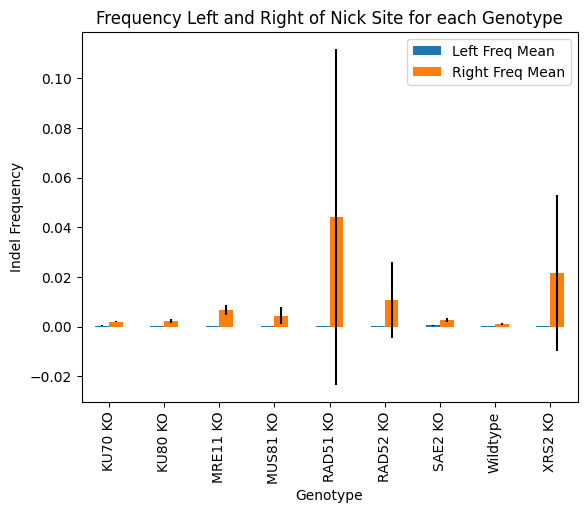

In [6]:
# now combine the individuals tables to create a consolidated table for the left and for the right
tableLeft = pd.merge(gen_freq_left1, gen_freq_left2, on='Genotype')
tableLeft = pd.merge(tableLeft, gen_freq_left3, on='Genotype')
tableLeft['Left Freq Mean'] = tableLeft.iloc[:, 1:4].mean(axis=1)
tableLeft['Left Freq Std'] = tableLeft.iloc[:, 1:4].std(axis=1)

tableRight = pd.merge(gen_freq_right1, gen_freq_right2, on='Genotype')
tableRight = pd.merge(tableRight, gen_freq_right3, on='Genotype')
tableRight['Right Freq Mean'] = tableRight.iloc[:, 1:4].mean(axis=1)
tableRight['Right Freq Std'] = tableRight.iloc[:, 1:4].std(axis=1)

# join tables (can drop the individual frequencies)
KOtableJoined = pd.merge(tableLeft, tableRight, on='Genotype')  # [['Genotype', 'Left Freq Mean', 'Left Freq Std', 'Right Freq Mean', 'Right Freq Std']]

ax = KOtableJoined.plot.bar(x='Genotype', y=['Left Freq Mean', 'Right Freq Mean'], yerr=KOtableJoined[['Left Freq Std', 'Right Freq Std']].T.values)
plt.title('Frequency Left and Right of Nick Site for each Genotype')
plt.ylabel('Indel Frequency')
plt.show()


Do the same steps as above but for the overexpression (OE) data

In [7]:
# Select the revelant columns
OE_gen_pos_freq1 = OE_indels1_df[['Genotype', 'Position','Freq']]
OE_gen_pos_freq2 = OE_indels2_df[['Genotype', 'Position','Freq']]
OE_gen_pos_freq3 = OE_indels3_df[['Genotype', 'Position','Freq']]



# Split each table into left of the split or right of the split
tableLeft1 = OE_gen_pos_freq1.where(OE_gen_pos_freq1['Position'] < 2093).dropna()
tableRight1 = OE_gen_pos_freq1.where(OE_gen_pos_freq1['Position'] > 2093).dropna()

tableLeft2 = OE_gen_pos_freq2.where(OE_gen_pos_freq2['Position'] < 2093).dropna()
tableRight2 = OE_gen_pos_freq2.where(OE_gen_pos_freq2['Position'] > 2093).dropna()

tableLeft3 = OE_gen_pos_freq3.where(OE_gen_pos_freq3['Position'] < 2093).dropna()
tableRight3 = OE_gen_pos_freq3.where(OE_gen_pos_freq3['Position'] > 2093).dropna()


# Group each table on the genotype name, sum up the frequency
gen_freq_left1 = tableLeft1.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_left1.rename(columns={'Freq': 'Left Freq 1'}, inplace=True)    # inplace allows the original table to be modified
gen_freq_right1 = tableRight1.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_right1.rename(columns={'Freq': 'Right Freq 1'}, inplace=True)    # inplace allows the original table to be modified

gen_freq_left2 = tableLeft2.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_left2.rename(columns={'Freq': 'Left Freq 2'}, inplace=True)    # inplace allows the original table to be modified
gen_freq_right2 = tableRight2.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_right2.rename(columns={'Freq': 'Right Freq 2'}, inplace=True)    # inplace allows the original table to be modified

gen_freq_left3 = tableLeft3.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_left3.rename(columns={'Freq': 'Left Freq 3'}, inplace=True)    # inplace allows the original table to be modified
gen_freq_right3 = tableRight3.drop('Position', axis=1).groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq_right3.rename(columns={'Freq': 'Right Freq 3'}, inplace=True)    # inplace allows the original table to be modified


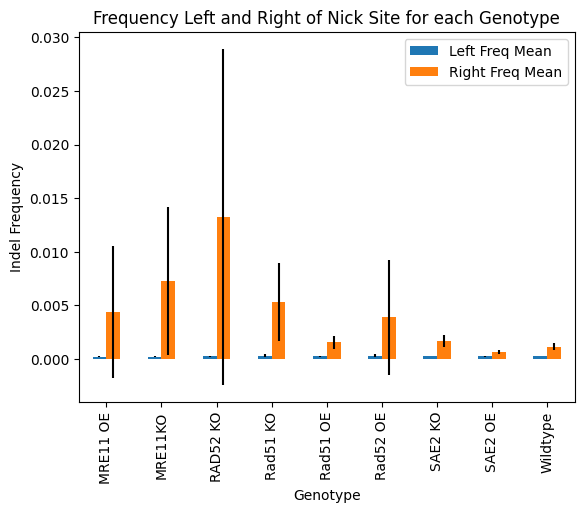

In [8]:
# now combine the individuals tables to create a consolidated table for the left and for the right
tableLeft = pd.merge(gen_freq_left1, gen_freq_left2, on='Genotype')
tableLeft = pd.merge(tableLeft, gen_freq_left3, on='Genotype')
tableLeft['Left Freq Mean'] = tableLeft.iloc[:, 1:4].mean(axis=1)
tableLeft['Left Freq Std'] = tableLeft.iloc[:, 1:4].std(axis=1)

tableRight = pd.merge(gen_freq_right1, gen_freq_right2, on='Genotype')
tableRight = pd.merge(tableRight, gen_freq_right3, on='Genotype')
tableRight['Right Freq Mean'] = tableRight.iloc[:, 1:4].mean(axis=1)
tableRight['Right Freq Std'] = tableRight.iloc[:, 1:4].std(axis=1)

# join tables (can drop the individual frequencies)
OEtableJoined = pd.merge(tableLeft, tableRight, on='Genotype')  # [['Genotype', 'Left Freq Mean', 'Left Freq Std', 'Right Freq Mean', 'Right Freq Std']]

ax = OEtableJoined.plot.bar(x='Genotype', y=['Left Freq Mean', 'Right Freq Mean'], yerr=OEtableJoined[['Left Freq Std', 'Right Freq Std']].T.values)
plt.title('Frequency Left and Right of Nick Site for each Genotype')
plt.ylabel('Indel Frequency')
plt.show()

QUESTION 3: DISPLAY THE INDEL LENGTH FOR EACH GENOTYPE (BOX AND WHISKER)
Note that the indel length is different for each sample name within a replicate, as well as between replicates
Should I be taking the mean of anything? 
Each column has to be a genotype for the box plots to work

In [9]:
# Select the revelant columns: Working with the KO and OE separately
gen_len1 = KO_indels1_df[['Genotype', 'length_of_indel']]
gen_len2 = KO_indels2_df[['Genotype', 'length_of_indel']]
gen_len3 = KO_indels3_df[['Genotype', 'length_of_indel']]

OE_gen_len1 = OE_indels1_df[['Genotype', 'length_of_indel']]
OE_gen_len2 = OE_indels2_df[['Genotype', 'length_of_indel']]
OE_gen_len3 = OE_indels3_df[['Genotype', 'length_of_indel']]


# append the tables together
appended1 = pd.concat([gen_len1, gen_len2], axis=0, ignore_index=True)
appended = pd.concat([appended1, gen_len3], axis=0, ignore_index=True)
indices = list(appended.index.values) 
appended['index'] = indices

OEappended1 = pd.concat([OE_gen_len1, OE_gen_len2], axis=0, ignore_index=True)
OEappended = pd.concat([OEappended1, OE_gen_len3], axis=0, ignore_index=True)
OEindices = list(OEappended.index.values) 
OEappended['index'] = OEindices



# pivot so the genotype are the columns
# the table will have NaN values, but the boxplots method can handle this
# column names: [('length_of_indel', 'KU70 KO'), ('length_of_indel', 'KU80 KO'), ('length_of_indel', 'MRE11 KO'), ('length_of_indel', 'MUS81 KO'), ('length_of_indel', 'RAD51 KO'), ('length_of_indel', 'RAD52 KO'), ('length_of_indel', 'SAE2 KO'), ('length_of_indel', 'Wildtype'), ('length_of_indel', 'XRS2 KO')]
table = pd.pivot_table(appended, index='index', columns="Genotype", aggfunc=lambda x: x)
table.columns = ['KU70 KO', 'KU80 KO', 'MRE11 KO', 'MUS81 KO', 'RAD51 KO', 'RAD52 KO', 'SAE2 KO', 'Wildtype', 'XRS2 KO']

OEtable = pd.pivot_table(OEappended, index='index', columns="Genotype", aggfunc=lambda x: x)
# print(OEtable.columns.tolist())
OEtable.columns = ['MRE11 OE', 'MRE11 KO', 'RAD52 KO', 'Rad51 KO', 'Rad51 OE', 'Rad52 OE', 'SAE2 KO', 'SAE2 OE', 'Wildtype']



# Customize the boxplot
boxprops = dict(linestyle='-', linewidth=2, color='blue')
whiskerprops = dict(linestyle='-', linewidth=2, color='black')
meanprops = dict(marker='o', markerfacecolor='red', markersize=10, markeredgecolor='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='orange')




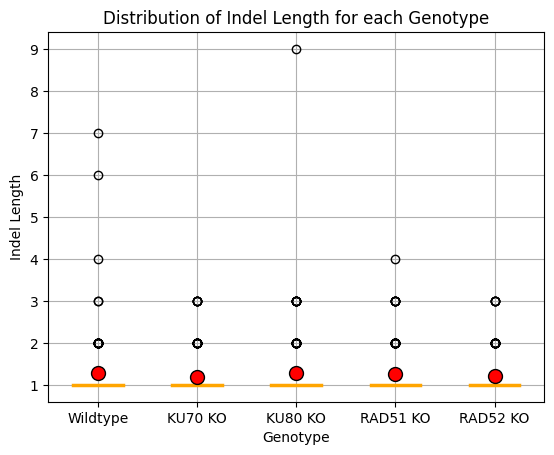

In [10]:
# KO part 1 boxplots
plt.figure()
table.boxplot(column=['Wildtype', 'KU70 KO', 'KU80 KO', 'RAD51 KO', 'RAD52 KO'], showmeans=True, meanprops=meanprops, whiskerprops=whiskerprops, showfliers=True, medianprops=medianprops, boxprops=boxprops)
plt.title('Distribution of Indel Length for each Genotype')
plt.ylabel('Indel Length')
plt.xlabel('Genotype')
plt.show()

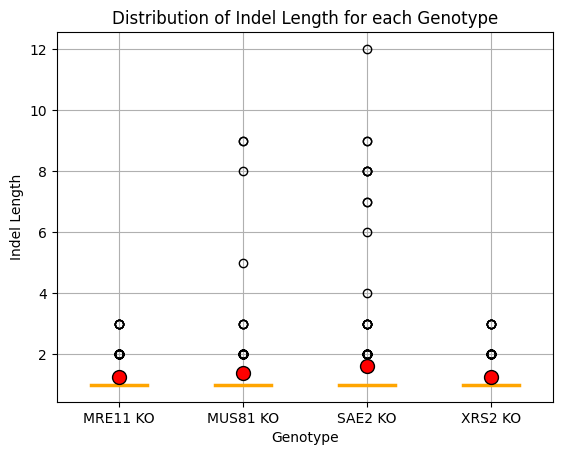

In [11]:
# KO part 2 
table.boxplot(column=['MRE11 KO', 'MUS81 KO', 'SAE2 KO', 'XRS2 KO'], showmeans=True, meanprops=meanprops, whiskerprops=whiskerprops, showfliers=True, medianprops=medianprops, boxprops=boxprops)
plt.title('Distribution of Indel Length for each Genotype')
plt.ylabel('Indel Length')
plt.xlabel('Genotype')
plt.show()

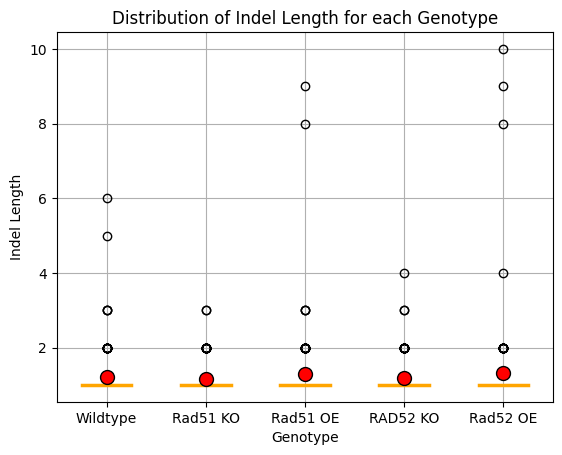

In [12]:
# OE part 1
OEtable.boxplot(column=['Wildtype', 'Rad51 KO', 'Rad51 OE', 'RAD52 KO', 'Rad52 OE'], showmeans=True, meanprops=meanprops, whiskerprops=whiskerprops, showfliers=True, medianprops=medianprops, boxprops=boxprops)
plt.title('Distribution of Indel Length for each Genotype')
plt.ylabel('Indel Length')
plt.xlabel('Genotype')
plt.show()

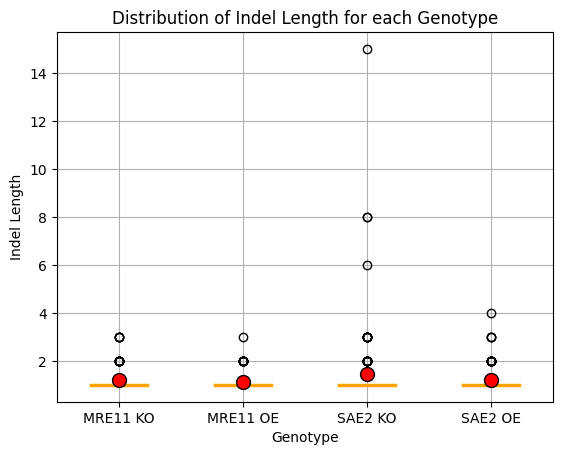

In [13]:
# OE part 2
OEtable.boxplot(column=['MRE11 KO', 'MRE11 OE', 'SAE2 KO', 'SAE2 OE'], showmeans=True, meanprops=meanprops, whiskerprops=whiskerprops, showfliers=True, medianprops=medianprops, boxprops=boxprops)
plt.title('Distribution of Indel Length for each Genotype')
plt.ylabel('Indel Length')
plt.xlabel('Genotype')
plt.show()

QUESTION 4: DISPLAY INDEL FREQUENCY BETWEEN DIFFERENT GENOTYPES
Same as question 2, however don't need to split between the position of the nick (left/right)

In [16]:
# Select the revelant columns, for OE and KO
gen_freq1_all = KO_indels1_df[['Genotype','Freq']]
gen_freq2_all = KO_indels2_df[['Genotype','Freq']]
gen_freq3_all = KO_indels3_df[['Genotype','Freq']]

OE_gen_freq1_all = OE_indels1_df[['Genotype','Freq']]
OE_gen_freq2_all = OE_indels2_df[['Genotype','Freq']]
OE_gen_freq3_all = OE_indels3_df[['Genotype','Freq']]


# Group each table on the genotype name, sum up the frequency
gen_freq1 = gen_freq1_all.groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq1.rename(columns={'Freq': 'Freq 1'}, inplace=True)    # inplace allows the original table to be modified

gen_freq2 = gen_freq2_all.groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq2.rename(columns={'Freq': 'Freq 2'}, inplace=True)   

gen_freq3 = gen_freq3_all.groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
gen_freq3.rename(columns={'Freq': 'Freq 3'}, inplace=True)   


OE_gen_freq1 = OE_gen_freq1_all.groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
OE_gen_freq1.rename(columns={'Freq': 'Freq 1'}, inplace=True)    # inplace allows the original table to be modified

OE_gen_freq2 = OE_gen_freq2_all.groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
OE_gen_freq2.rename(columns={'Freq': 'Freq 2'}, inplace=True)   

OE_gen_freq3 = OE_gen_freq3_all.groupby('Genotype').agg({'Freq': 'sum'}).reset_index()
OE_gen_freq3.rename(columns={'Freq': 'Freq 3'}, inplace=True)   



# now combine the individuals tables to create a consolidated table for the left and for the right
table1 = pd.merge(gen_freq1, gen_freq2, on='Genotype')
table = pd.merge(table1, gen_freq3, on='Genotype')
table['Freq Mean'] = table.iloc[:, 1:4].mean(axis=1)
table['Freq Std'] = table.iloc[:, 1:4].std(axis=1)

OEtable1 = pd.merge(OE_gen_freq1, OE_gen_freq2, on='Genotype')
OEtable = pd.merge(OEtable1, OE_gen_freq3, on='Genotype')
OEtable['Freq Mean'] = OEtable.iloc[:, 1:4].mean(axis=1)
OEtable['Freq Std'] = OEtable.iloc[:, 1:4].std(axis=1)



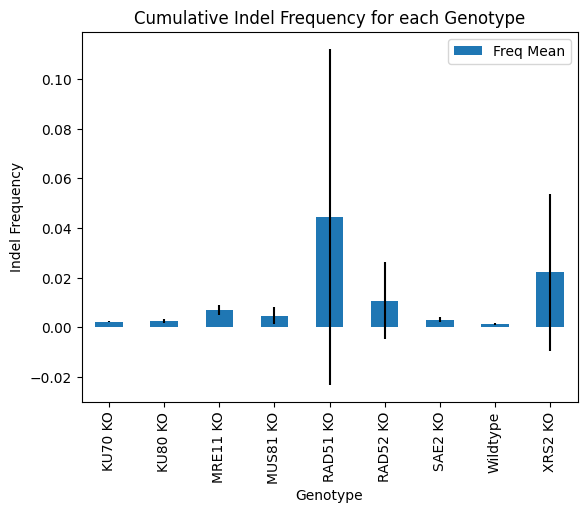

In [17]:
# Bar graph for the KO samples
ax = table.plot.bar(x='Genotype', y=['Freq Mean'], yerr=table[['Freq Std']].T.values)
plt.title('Cumulative Indel Frequency for each Genotype')
plt.ylabel('Indel Frequency')
plt.show()

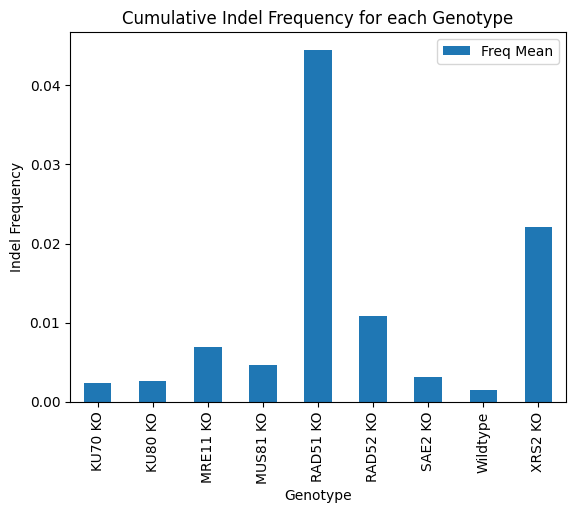

In [18]:
# Same bar graph as above but without error bar lines
ax = table.plot.bar(x='Genotype', y=['Freq Mean'])
plt.title('Cumulative Indel Frequency for each Genotype')
plt.ylabel('Indel Frequency')
plt.show()

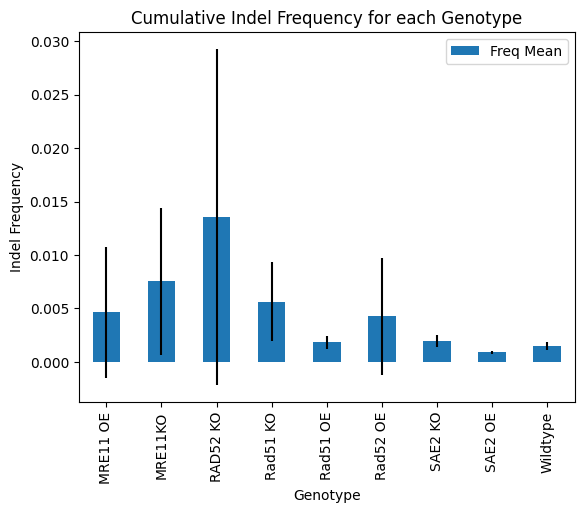

In [19]:
# Bar graph for the OE samples
ax = OEtable.plot.bar(x='Genotype', y=['Freq Mean'], yerr=OEtable[['Freq Std']].T.values)
plt.title('Cumulative Indel Frequency for each Genotype')
plt.ylabel('Indel Frequency')
plt.show()

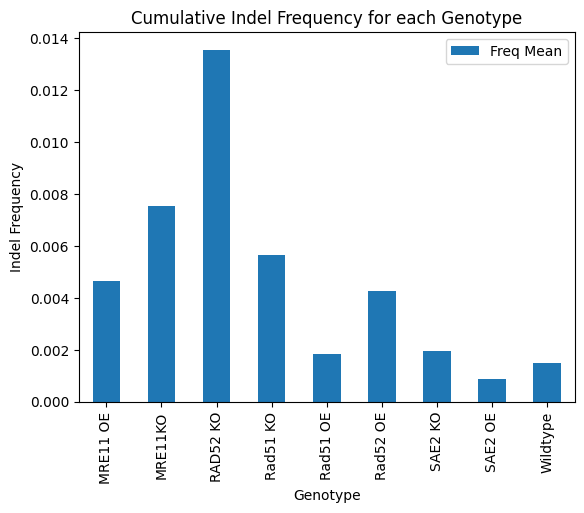

In [20]:
# Bar graph for the OE samples
ax = OEtable.plot.bar(x='Genotype', y=['Freq Mean'])
plt.title('Cumulative Indel Frequency for each Genotype')
plt.ylabel('Indel Frequency')
plt.show()